In [1]:
!pip install catboost interpret xgboost lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, average_precision_score

from catboost import CatBoostClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd '/content/drive/MyDrive/Parkinson_data_paper/'
    COLAB = True
    project_url = './'
except:
    COLAB = False
    project_url = './'

In [4]:
data = pd.read_csv(f'{project_url}/dataset/feature_engineered_dataset.csv', index_col=None)
data = data.drop("Session ID", axis=1)
data

Parkinson's Disease status   Age  Gender  \
0                           pd  61.0    Male   
1                        nonpd  58.0    Male   
2                           pd  67.0  Female   
3                        nonpd  61.0    Male   
4                           pd  62.0    Male   
..                         ...   ...     ...   
246                      nonpd  66.0    Male   
247                      nonpd  65.0    Male   
248                      nonpd  82.0    Male   
249                         pd  64.0    Male   
250                suspectedpd  55.0    Male   

                                          Race  \
0    Native Hawaiian or Other Pacific Islander   
1                                        White   
2                                        White   
3                                        White   
4                                        White   
..                                         ...   
246                                      White   
247                                      White   
248                                      White   
249                  Black or African American   
250                                      Asian   

     1. Mean deviation from centerline when tracing straight line (fraction of screen height)  \
0                                             0.023886                                          
1                                            -0.000934                                          
2                                             0.018477                                          
3                                             0.002205                                          
4                                             0.102513                                          
..                                                 ...                                          
246                                           0.008034                                          
247                                           0.004795                                          
248                                          -0.009453                                          
249                                           0.005400                                          
250                                          -0.002017                                          

     2. Amount of time taken to trace straight line (miliseconds)  \
0                                                  500              
1                                                 1500              
2                                                10500              
3                                                 1000              
4                                                 3500              
..                                                 ...              
246                                               1500              
247                                               6000              
248                                              11000              
249                                               3000              
250                                               3000              

     2.5. Amount of time taken to trace straight line with respect to window width (miliseconds)  \
0                                             0.347222                                             
1                                             1.169135                                             
2                                             5.468750                                             
3                                             0.779423                                             
4                                             1.822917                                             
..                                                 ...                                             
246                                           1.169135                                             
247                             

In [5]:
data["Parkinson's Disease status"] = data["Parkinson's Disease status"].replace("suspectedpd", "pd")

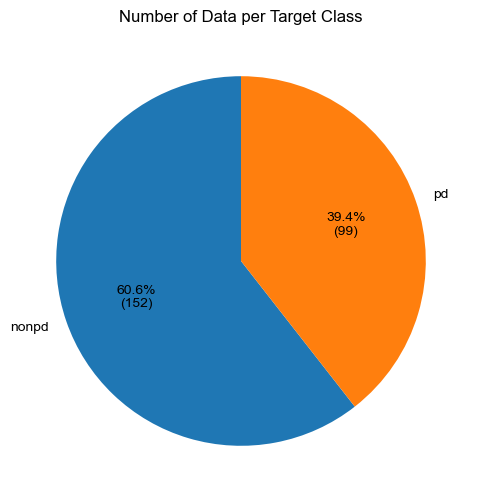

In [6]:
# plt.figure(dpi=1200)
def percent_with_num(values):
    def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format

counts = data["Parkinson's Disease status"].value_counts()

plt.figure(figsize=(6, 6))
# plt.figure(dpi=1200)
plt.pie(counts, labels=counts.index, autopct=percent_with_num(counts), startangle=90)
plt.title("Number of Data per Target Class")

sns.set_style("whitegrid")
sns.despine()
plt.show()

In [7]:
featureset= data.drop("Parkinson's Disease status", axis=1)
label= data["Parkinson's Disease status"]

In [8]:
categorical_cols = featureset.select_dtypes(include='object').columns
feature_encoded = pd.get_dummies(featureset, columns=categorical_cols, prefix=categorical_cols, dtype='int')
feature_encoded

Age  \
0    61.0   
1    58.0   
2    67.0   
3    61.0   
4    62.0   
..    ...   
246  66.0   
247  65.0   
248  82.0   
249  64.0   
250  55.0   

     1. Mean deviation from centerline when tracing straight line (fraction of screen height)  \
0                                             0.023886                                          
1                                            -0.000934                                          
2                                             0.018477                                          
3                                             0.002205                                          
4                                             0.102513                                          
..                                                 ...                                          
246                                           0.008034                                          
247                                           0.004795                                          
248                                          -0.009453                                          
249                                           0.005400                                          
250                                          -0.002017                                          

     2. Amount of time taken to trace straight line (miliseconds)  \
0                                                  500              
1                                                 1500              
2                                                10500              
3                                                 1000              
4                                                 3500              
..                                                 ...              
246                                               1500              
247                                               6000              
248                                              11000              
249                                               3000              
250                                               3000              

     2.5. Amount of time taken to trace straight line with respect to window width (miliseconds)  \
0                                             0.347222                                             
1                                             1.169135                                             
2                                             5.468750                                             
3                                             0.779423                                             
4                                             1.822917                                             
..                                                 ...                                             
246                                           1.169135                                             
247                                           3.906250                                             
248                                           7.638889                                             
249                                           2.196193                                             
250                                           2.343750                                             

     3. Percentage of points traced inside straight line  \
0                                             1.000000     
1                                             1.000000     
2                                             1.000000     
3                                             1.000000     
4                                             0.285714     
..                                                 ...     
246                                           1.000000     
247                                           1.000000     
248                                           0.863636     
249                                           1.000000

In [9]:
label_encoded = LabelEncoder().fit_transform(label)

In [10]:
X_train, y_train = feature_encoded, label_encoded

In [11]:
numerical_columns = featureset.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
# X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [12]:
def k_fold_validation(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)
    f1 = []
    accuracy = []
    precision_scores = []
    sensitivity = []
    specificity = []
    fpr_list = []
    auc_list = []
    rec_list = []
    auprc_list = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_fold_train, X_fold_test = X.iloc[train_index], X.iloc[test_index]
        y_fold_train, y_fold_test = y[train_index], y[test_index]

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_test)

        f1.append(f1_score(y_fold_test, y_pred))
        accuracy.append(accuracy_score(y_fold_test, y_pred))
        precision_scores.append(precision_score(y_fold_test, y_pred))
        sensitivity.append(recall_score(y_fold_test, y_pred, pos_label=1))
        specificity.append(recall_score(y_fold_test, y_pred, pos_label=0))

        y_proba = model.predict_proba(X_fold_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_fold_test, y_proba)
        fpr_interp = np.linspace(0, 1, 100)
        tpr_interp = np.interp(fpr_interp, fpr, tpr)
        fpr_list.append(tpr_interp)
        auc_list.append(auc(fpr, tpr))

        precision, recall, _ = precision_recall_curve(y_fold_test, y_proba)
        recall_interp = np.linspace(0, 1, 100)
        precision_interp = np.interp(recall_interp, recall[::-1], precision[::-1])
        rec_list.append(precision_interp)
        auprc_list.append(auc(recall, precision))

    return {
        'f1_scores': f1, 'accuracy': accuracy, 'precision': precision_scores,
        'sensitivity': sensitivity, 'specificity': specificity,
        'auc': auc_list, 'auprc': auprc_list, 'fpr_list': fpr_list, 'rec_list': rec_list
    }

In [13]:
def plot_roc_prc_curve(results):
    tpr_array = np.array(results['fpr_list'])
    tpr_mean = tpr_array.mean(axis=0)
    tpr_std = tpr_array.std(axis=0)

    prec_array = np.array(results['rec_list'])
    prec_mean = prec_array.mean(axis=0)
    prec_std = prec_array.std(axis=0)

    fpr_interp = np.linspace(0, 1, 100)
    recall_interp = np.linspace(0, 1, 100)

    mean_auc = np.mean(results['auc'])
    std_auc = np.std(results['auc'])

    mean_auprc = np.mean(results['auprc'])
    std_auprc = np.std(results['auprc'])

    plt.figure(figsize=(12, 5), dpi=1200)

    plt.subplot(1, 2, 1)
    plt.plot(fpr_interp, tpr_mean, color='#1b9e77')
    plt.fill_between(fpr_interp, tpr_mean - tpr_std, tpr_mean + tpr_std, color='#1b9e77', alpha=0.2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='#aaaaaa')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean AUROC (5-Fold CV)')

    auroc_handles = [
        Line2D([0], [0], color='#1b9e77', lw=2, label=f'Mean AUROC = {mean_auc:.3f}'),
        Patch(facecolor='#1b9e77', alpha=0.2, label=f'Standard Deviation ± {std_auc:.3f}')
    ]
    plt.legend(handles=auroc_handles, loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall_interp, prec_mean, color='#d95f02')
    plt.fill_between(recall_interp, prec_mean - prec_std, prec_mean + prec_std, color='#d95f02', alpha=0.2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Mean AUPRC (5-Fold CV)')

    auprc_handles = [
        Line2D([0], [0], color='#d95f02', lw=2, label=f'Mean AUPRC = {mean_auprc:.3f}'),
        Patch(facecolor='#d95f02', alpha=0.2, label=f'Standard Deviation ± {std_auprc:.3f}')
    ]
    plt.legend(handles=auprc_handles, loc='lower left')

    plt.tight_layout()
    plt.show()


In [14]:
base_models = [
    ('catboost', CatBoostClassifier(random_state=57, verbose=False)),
    ('xgboost', XGBClassifier(random_state= 57)),
    ('lightgbm', LGBMClassifier(random_state=57, verbose=-1))
]
meta_learner = LogisticRegression()

In [15]:
cat_model = CatBoostClassifier(random_state=57, verbose=False)
ebm = ExplainableBoostingClassifier(random_state=57)
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    passthrough=True,
    cv=None
)

In [16]:
cat_results = k_fold_validation(cat_model, X_train, y_train)
plot_roc_prc_curve(cat_results)

In [17]:
ebm_results = k_fold_validation(ebm, X_train, y_train)
plot_roc_prc_curve(ebm_results)

In [18]:
meta_result = k_fold_validation(stacking_clf, X_train, y_train)
plot_roc_prc_curve(meta_result)

In [19]:
def plot_bar_chart(all_results):
    models = list(all_results.keys())

    mean_f1 = [np.mean(results['f1_scores']) for results in all_results.values()]
    std_f1 = [np.std(results['f1_scores']) for results in all_results.values()]
    mean_auc = [np.mean(results['auc']) for results in all_results.values()]
    std_auc = [np.std(results['auc']) for results in all_results.values()]
    mean_accuracy = [np.mean(results['accuracy']) for results in all_results.values()]
    std_accuracy = [np.std(results['accuracy']) for results in all_results.values()]
    mean_precision = [np.mean(results['precision']) for results in all_results.values()]
    std_precision = [np.std(results['precision']) for results in all_results.values()]
    mean_sensitivity = [np.mean(results['sensitivity']) for results in all_results.values()]
    std_sensitivity = [np.std(results['sensitivity']) for results in all_results.values()]
    mean_specificity = [np.mean(results['specificity']) for results in all_results.values()]
    std_specificity = [np.std(results['specificity']) for results in all_results.values()]

    metric_dataframes = [
        pd.DataFrame({"Metric": "F1 Score", "Algorithms": models, "Mean": mean_f1, "Std": std_f1}),
        pd.DataFrame({"Metric": "Accuracy", "Algorithms": models, "Mean": mean_accuracy, "Std": std_accuracy}),
        pd.DataFrame({"Metric": "Precision", "Algorithms": models, "Mean": mean_precision, "Std": std_precision}),
        pd.DataFrame({"Metric": "Sensitivity", "Algorithms": models, "Mean": mean_sensitivity, "Std": std_sensitivity}),
        pd.DataFrame({"Metric": "Specificity", "Algorithms": models, "Mean": mean_specificity, "Std": std_specificity}),
    ]

    metrics_df = pd.concat(metric_dataframes, ignore_index=True)

    model_colors = {
        "CatBoost": "#8da8d3",
        "EBM": "#a1d99b",
        "Meta Learner": "#f6c969"
    }

    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 6), dpi=1200)

    ax = sns.barplot(
        data=metrics_df,
        y="Metric",
        x="Mean",
        hue="Algorithms",
        palette=model_colors,
        errorbar=None
    )

    for i, row in metrics_df.iterrows():
        x = row["Mean"]
        xerr = row["Std"]
        metric_index = list(metrics_df["Metric"].unique()).index(row["Metric"])
        group_offset = -0.3 + 0.6 * models.index(row["Algorithms"]) / max(len(models) - 1, 1)
        y = metric_index + group_offset
        ax.errorbar(x, y, xerr=xerr, fmt='none', ecolor='black', capsize=2, lw=0.8)

        ax.annotate(f"{x:.4f} ± {xerr:.4f}",
                    (x + xerr + 0.005, y),
                    va='center', ha='left', fontsize=8)

    plt.title("Comparison of Models across Multiple Metrics")
    plt.xlabel("Score")
    plt.ylabel("Metrics")
    plt.xlim(0, metrics_df["Mean"].max() + metrics_df["Std"].max() + 0.05)
    plt.xticks(np.arange(0, 1.01, 0.1))

    plt.legend(title="Algorithms", loc='lower left', frameon=True)
    plt.tight_layout()
    plt.show()


In [20]:
all_results = {
    'CatBoost': cat_results,
    'EBM': ebm_results,
    'Meta Learner': meta_result
}

plot_bar_chart(all_results)